In [1]:
import os

DIR = "../datasets/samanatar"
lines = []

for file in os.listdir(DIR):
    with open(f"{DIR}/{file}", "r", encoding="utf-8") as fp:
        lines += fp.readlines()
    
print(len(lines))

49774246


In [2]:
unique_lines = list(set(lines))

print(len(unique_lines))

16729102


In [3]:
unique_lines = sorted(unique_lines)

In [4]:
import matplotlib.pyplot as plt
import re
import unicodedata

In [5]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD", 3: "UNK"}  # Add UNK token
        self.n_words = 4  # Start with 4 to include UNK

    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word.lower())

    def add_word(self, word):
        word = word.lower()
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

    def build_vocab(self, max_vocab_size=1e8):
        if max_vocab_size <= self.n_words:
            raise ValueError("max_vocab_size must be greater than the number of existing tokens")

        # Sort words by frequency in descending order
        sorted_words = sorted(self.word2count, key=self.word2count.get, reverse=True)

        # Add most frequent words to vocabulary
        if max_vocab_size < len(sorted_words):
            limit  = max_vocab_size - self.n_words
        else:
            limit = len(sorted_words)
        for word in sorted_words[:limit]:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1


def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )

def filter_sentence(sentence):
    pattern = r"[^A-Za-z0-9\s\t,;.:-?!'\"]"

    if sentence is None:
        return False
    
    sentence = sentence.strip()
    if len(sentence) == 0:
        return False
    
    if re.search(pattern, sentence):
        return False
    
    word_count = len(sentence.split(' '))
    if word_count < 5 or word_count > 30:
        return False

    return True

def normalize_lines(lines):
    fl = []
    for s in lines:
        if filter_sentence(s):
            s = unicode_to_ascii(str(s).strip())
            s = re.sub(r"(['\".!?:;,-])", r" \1 ", s)
            s = re.sub(r"\s+", " ", s)
            # s = re.sub(r"[^a-zA-Z0-9.,!?]+", r" ", s)
            fl.append(s.strip())
    return fl

In [6]:
def prepare_data(unique_lines):
    en_lang = Lang("english")

    unique_lines = normalize_lines(unique_lines)

    print("Read %s sentences" % len(unique_lines))
    print("Counting words...")
    for en_line in unique_lines:
        en_lang.add_sentence(en_line)

    en_lang.build_vocab()

    print("Counted words:")
    print(en_lang.name, en_lang.n_words)
    return (en_lang, unique_lines)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_word_frequencies(lang, title):
    frequencies = list(lang.word2count.values())

    # Histogram with log scale
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(frequencies, bins=np.logspace(0, np.log10(max(frequencies)), 50))
    plt.xscale('log')
    plt.title(f"Word Frequency Distribution - {title}")
    plt.xlabel("Frequency (Log Scale)")
    plt.ylabel("Number of Words")

    # CDF
    from statsmodels.distributions.empirical_distribution import ECDF
    plt.subplot(1, 2, 2)
    ecdf = ECDF(frequencies)
    plt.plot(ecdf.x, ecdf.y)
    plt.xscale('log')
    plt.title(f"Word Frequency Distribution (CDF) - {title}")
    plt.xlabel("Frequency (Log Scale)")
    plt.ylabel("Cumulative Probability")

    plt.tight_layout()
    plt.show()

Read 11044513 sentences
Counting words...
Counted words:
english 651316


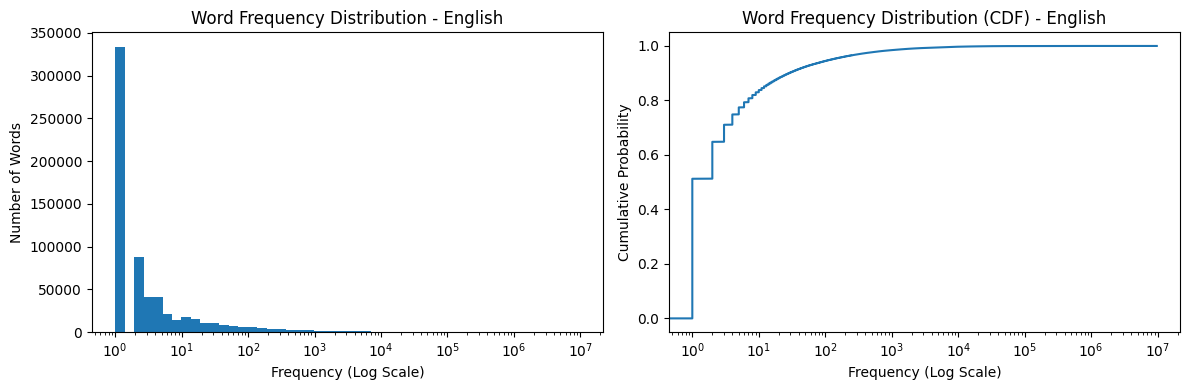

In [8]:
import pickle

if __name__ == "__main__":
    if not os.path.exists("samanatar/en_lang"):
        en_lang, en_lines = prepare_data(unique_lines=unique_lines)
    else:
        with open("samanatar/en_lang", "rb") as fp:
            en_lang = pickle.load(fp)

    nel = []
    for line in en_lines:
        nel.append(line + "\n")
    with open("en_lines.txt", "w", encoding="utf-8") as fp:
        fp.writelines(nel)

    plot_word_frequencies(en_lang, "English")

In [9]:
import pickle

with open("samanatar/en_lang", "ab") as fp:
    pickle.dump(en_lang, fp)

In [10]:
loi = []
ol = []
for line in en_lines:
    flag = False
    words = line.split(' ')
    for word in words:
        if en_lang.word2count[word.lower()] <= 100:
            loi.append(line + "\n")
            flag = True
            break
    if not flag:
        ol.append(line + "\n")

with open("loi.txt", "w", encoding="utf-8") as fp:
    fp.writelines(loi)

In [11]:
with open("ol.txt", "w", encoding="utf-8") as fp:
    fp.writelines(ol)

8706799


In [12]:
assert (len(en_lines) == len(ol) + len(loi))

In [13]:
len(ol), len(loi), len(en_lines)

(8706799, 2337714, 11044513)